## Colab install

The below cell installs necessary packages if running this notebook from Google Colaboratory. You can read more about colab [here](https://colab.research.google.com/notebooks/welcome.ipynb). Colaboratory provides a free runtime to execute this notebook in. If you'd like to try it out, click the following link:

[View in Colaboratory](https://colab.research.google.com/github/alistairewj/tree-prediction-tutorial/blob/master/trees-classification.ipynb)

In [1]:
# install packages if needed
try:
    import pydotplus
except:
    !pip install pydotplus
    # we also need to upgrade scikit-learn to use some new pipeline features later
    # require scikit-learn > 0.20.1
    !pip install scikit-learn --upgrade

import pydotplus

# install graphviz
try:
    !apt-get install graphviz -y
except:
    pass

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


# Tree based methods for prediction

This tutorial is meant to be an introduction to tree based methods for prediction. We start with the most basic model, a decision tree, and work our way up to the more recent work on gradient boosting. We will be alternating between sample datasets available with scikit-learn and a medical dataset made available in this repository (and originally sourced from PhysioNet).

In [2]:
from __future__ import print_function

import errno
import os

import numpy as np
import pandas as pd
import collections

from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import datasets
import pydotplus

import matplotlib
import matplotlib.pyplot as plt

# used to display trees
from IPython.display import Image

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams.update({'font.size': 20})

Below we define a helper function (`plot_model_pred_2d`) which will help us plot (i) the decision that the tree makes as the background colour and (ii) the actual data coloured with their true outcome. So, if blue overlaps with blue on our plot, we can be fairly happy that the algorithm is working well. Note that while there are more rigorous and quantitative forms of evaluating models, one can gain a lot of insight from visualizing the data.

In order to make the colormaps have the same color as the decision tree, we use a `make_colormap` helper function.

In [3]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return matplotlib.colors.LinearSegmentedColormap('CustomMap', cdict)

def plot_model_pred_2d(mdl, X, y, cm=None, cbar=True, xlabel=None, ylabel=None):
    # look at the regions in a 2d plot
    # based on scikit-learn tutorial plot_iris.html
    
    # get minimum and maximum values
    x0_min = X[:, 0].min()
    x0_max = X[:, 0].max()
    x1_min = X[:, 1].min()
    x1_max = X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                         np.linspace(x1_min, x1_max, 100))

    Z = mdl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if not cm:
        # custom colormap
        #e58139f9 - orange
        #399de5e0 - to blue
        s = list()

        lo = np.array(matplotlib.colors.to_rgb('#e5813900'))
        hi = np.array(matplotlib.colors.to_rgb('#399de5e0'))

        for i in range(255):
            s.append( list((hi-lo)*(float(i)/255)+lo) )
        cm = make_colormap(s)
    
    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap=cm)

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X[:, 0], X[:, 1], c=color, edgecolor='k', linewidth=2,
                marker='o', s=60, cmap=cm)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.axis("tight")
    #plt.clim([-1.5,1.5])
    if cbar:
        plt.colorbar()

In [4]:
def create_graph(mdl, cmap=None):
    # cmap is a colormap
    # e.g. cmap = matplotlib.cm.coolwarm( np.linspace(0.0, 1.0, 256, dtype=float) )
    tree_graph = tree.export_graphviz(mdl, out_file=None,
                             feature_names=feat, 
                             filled=True, rounded=True)
    graph = pydotplus.graphviz.graph_from_dot_data(tree_graph)
    
    # get colormap
    if cmap:
        # remove transparency
        if cmap.shape[1]==4:
            cmap = cmap[:,0:2]
        
        nodes = graph.get_node_list()
        for node in nodes:
            if node.get_label():
                # get number of samples in group 1 and group 2
                num_samples = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]

                # proportion that is class 2
                cm_value = float(num_samples[1]) / float(sum(num_samples))
                # convert to (R, G, B, alpha) tuple
                cm_value = matplotlib.cm.coolwarm(cm_value)
                cm_value = [int(np.ceil(255*x)) for x in cm_value]
                color = '#{:02x}{:02x}{:02x}'.format(cm_value[0], cm_value[1], cm_value[2])
                node.set_fillcolor(color)

    Image(graph.create_png())
    return graph

# Dataset

The dataset we'll use is a classic: Fisher's iris. This data was collected by Edgar Anderson and was used by Fisher to demonstrate Linear Discriminant Analysis (LDA). We won't talk about LDA in this tutorial but it's an interesting technique worth learning about!

The iris dataset includes the petal and sepal measurements for three types of flowers. The below code:

* loads in the dataset
* prints out a brief description
* extracts two columns of the data into `X` 
* extracts the class labels into `y`

Note that we only use two columns of data because we'd like to visualize the classifier. Also, we only use data from index `50` onward because we'd like to focus on two plants: versicolour and virginica.

In [5]:
# real example
df = datasets.load_iris()

# if you want a description of the dataset, uncomment the below line
print(df['DESCR'])

idx = [0,2]
X = df['data'][50:,idx]
y = df['target'][50:]

# recode target as -1 and 1
y[y==1] = -1
y[y==2] =  1

feat = [df['feature_names'][x] for x in idx]

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

# Decision trees

Let's build the simplest tree model we can think of: a classification tree with only one split. Decision trees of this form are commonly referred to under the umbrella term Classification and Regression Trees (CART) [1]. While we will only be looking at classification here, regression isn't too different. After grouping the data (which is essentially what a decision tree does), classification involves assigning all members of the group to the majority class of that group during training. Regression is the same, except you would assign the average value, not the majority. In the case of a decision tree with one split, often called a "stump", the model will partition the data into two groups, and assign classes for those two groups based on majority vote. There are many parameters available for the `DecisionTreeClassifier` class; by specifying `max_depth=1` we will build a decision tree with only one split - i.e. of depth 1.

[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.

In [6]:
# specify max_depth=1 so we train a stump, i.e. a tree with only 1 split
mdl = tree.DecisionTreeClassifier(max_depth=1)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X,y)

Since our model is so simple, we can actually look at the full decision tree.

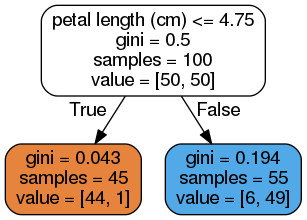

In [7]:
graph = create_graph(mdl)
Image(graph.create_png())

Here we see three nodes: a white node at the top, an orange node in the lower left, and a blue node in the lower right.

The top (white) node is the root of the tree: it contains all the data. Let's read this node bottom to top, starting with `value = [50, 50]`. This line is telling us the current class balance: there are `50` observations of class 1, and `50` observations of class 2. In our iris data, that translates to `50` versicolour and `50` virginica. Moving up a line, `samples = 100` reminds us how many rows of data are assessed at this node. Since it's the root of our tree, all the data is assessed. Moving up again we have `gini = 0.5`. This is the Gini index, and is very important as it is the value that is used to split data. The Gini index is a measure of impurity - the higher the value is, the bigger mix of classes that you have. Right now we have a 50/50 split of two classes, and as a result, the gini index is `0.5`: about as bad as we can do. Ideally, we'd want this value to be 0, which would indicate that only one class of data is present in that node.

Finally, the top line in the white node is the decision rule that has been learned for that node. That is, this line indicates what value the node will split the data on. In this case we've moved observations with petal length <= 4.75 cm to the left node, and implicitly all observations with petal length > 4.75 cm are moved into the right node. Looking in the two nodes, we can also see that the value for `gini` is lower in both, indicating that these nodes are more homogeneous. Looking at the `value` line, we can see that the left node has 44 observations in class 1, and 1 observation in class 2. This is much better than the 50/50 split we had earlier!

It's nice to look at the `gini` coefficient because that's actually what the algorithm uses to determine a split. It evaluates every single feature (petal length, etc) at every possible split (4.75, 4.76, ...) to find the split which minimizes the gini in the two resultant nodes. Evaluating every possibility at each iteration and picking the best one is called a *greedy* approach.

Let's take a look at what this decision boundary actually looks like.

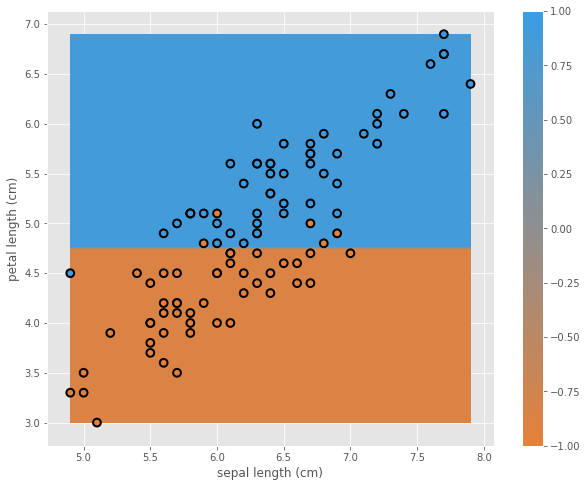

In [8]:
# look at the regions in a 2d plot
# based on scikit-learn tutorial plot_iris.html
plt.figure(figsize=[10,8])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

Above we can see the decision boundary of 4.75 cm for petal length (y-axis). We can also see a blue circle on the far left - the 1 point we misclassified as class 2 which had petal length < 4.75cm.

Of course we are using a very simple model - let's see what happens when we increase the depth to 5.

In [9]:
mdl = tree.DecisionTreeClassifier(max_depth=5)
mdl = mdl.fit(X,y)

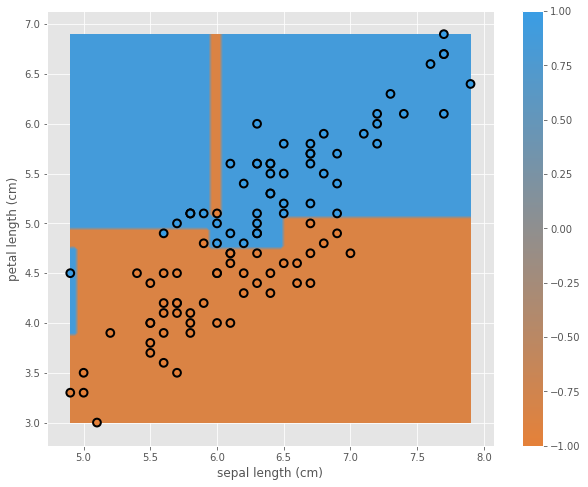

In [10]:
plt.figure(figsize=[10,8])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

Now our tree is more complicated - we can see a few vertical boundaries as well as the horizontal one from before. Some of these we may like - for example the movement of the boundary upward around septal length of ~6.7 cm. However, some appear unnatural; the vertical bar of classification done around a septal length of 6.1 cm, for example. Let's look at the tree itself.

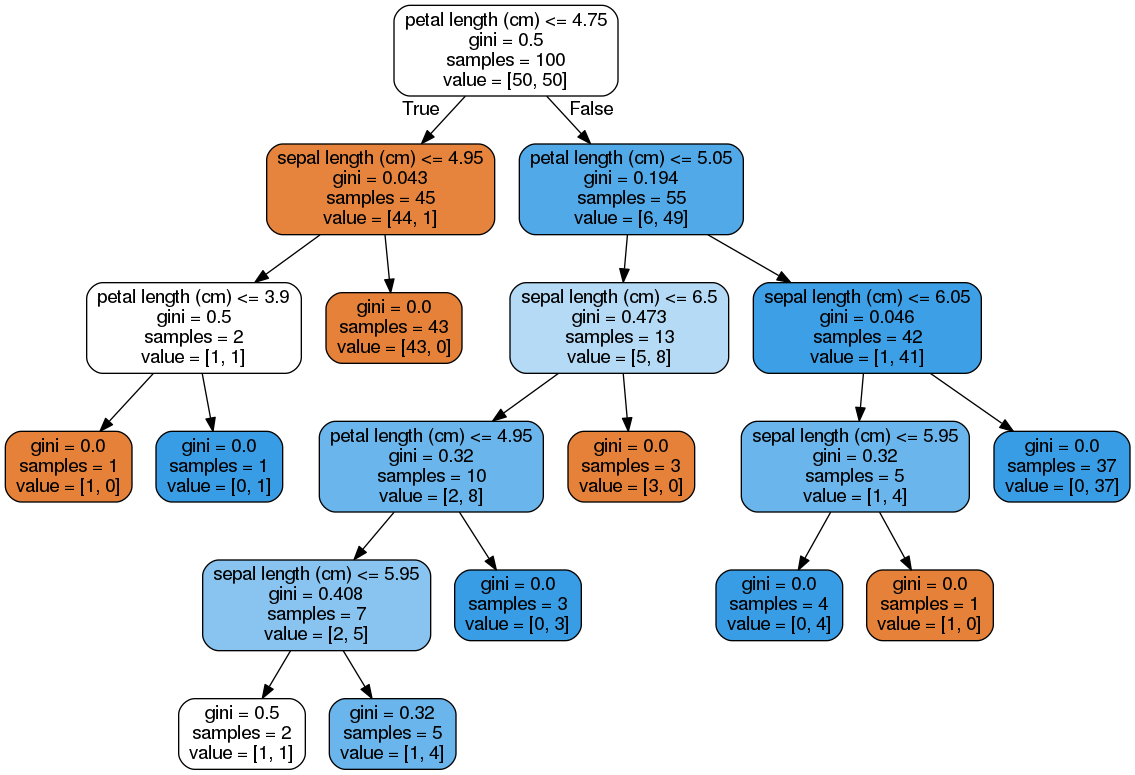

In [11]:
tree_graph = tree.export_graphviz(mdl, out_file=None,
                         feature_names=feat, 
                         filled=True, rounded=True)  
graph = pydotplus.graphviz.graph_from_dot_data(tree_graph) 
Image(graph.create_png())  

On the far right we see our culprit.

* value = [1, 41] -> Split on Sepal length <= 6.05, go left
* value = [1, 4] -> Split on Sepal Length <= 5.95, go *right* (i.e. sepal length > 5.95)
* value = [1, 0] -> gini to 0.0, hurray!

i.e. if the sepal length <= 6.05, and it is > 5.95, we classify it as class 1 (orange), otherwise it's class 0. Having an entire rule based upon this one observation seems silly, but it's perfectly logical as at the moment the **only** objective the algorithm cares about is minimizing the gini - and a `gini = 0.0` is lower than a `gini = 0.0465` - so it continues splitting until it gets there.

This is where "pruning" the tree comes in (trust me, the gardening influenced play on words is just starting).

In [12]:
def prune(dt, min_samples_leaf = 1):
    # Pruning is done by the "min_samples_leaf" property of decision trees
    if dt.min_samples_leaf >= min_samples_leaf:
        print('Decision tree is pruned at an equal or higher level.')
    else:
        # update prune parameter
        dt.min_samples_leaf = min_samples_leaf
        
        # loop through each node of the tree
        tree = dt.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                # we can't delete splits because they are fixed in the model
                # instead, we remove the split by setting the child values to -1
                tree.children_left[i]=-1
                tree.children_right[i]=-1

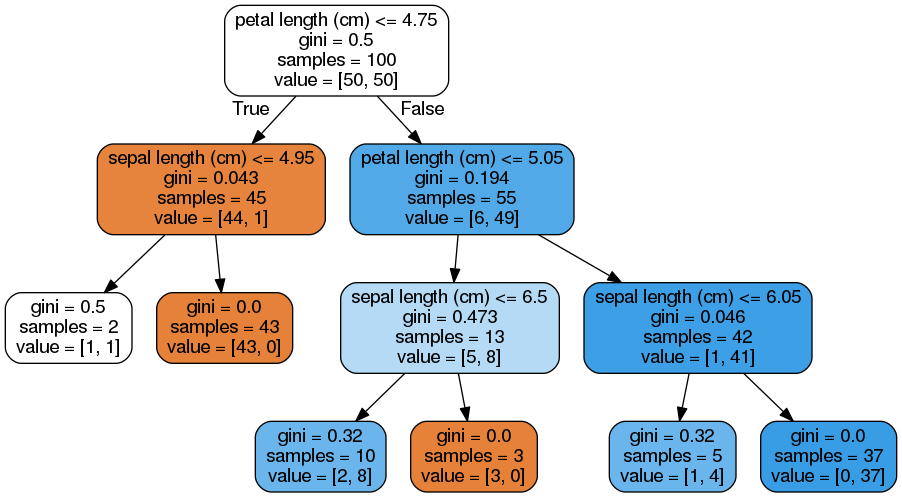

In [13]:
# let's prune the model and look again
prune(mdl, min_samples_leaf = 10)
tree_graph = tree.export_graphviz(mdl, out_file=None,
                         feature_names=feat, 
                         filled=True, rounded=True)  
graph = pydotplus.graphviz.graph_from_dot_data(tree_graph) 
Image(graph.create_png())  

Above, we can see that our second tree is (1) smaller in depth, and (2) never splits a node with <= 10 samples. We can look at the decision surface for this tree:

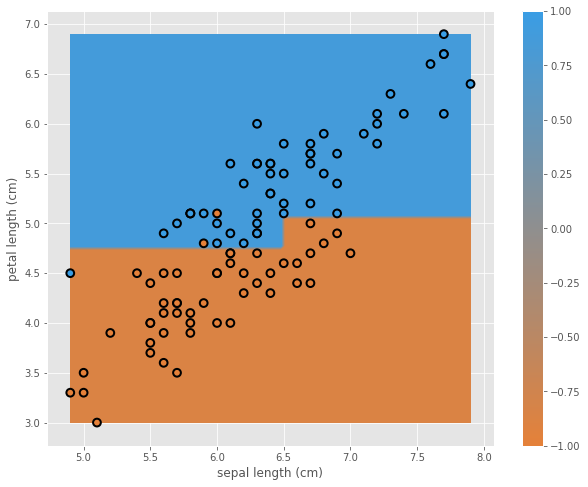

In [14]:
plt.figure(figsize=[10,8])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

Our pruned decision tree has a much more intuitive boundary, but does make some errors. We have reduced our performance in an effort to simplify the tree. This is the classic machine learning problem of trading off complexity with error.

Note that, in order to do this, we "invented" the minimum samples per leaf node of 10. Why 10? Why not 5? Why not 20? The answer is: it depends on the dataset. Heuristically choosing these parameters can be time consuming, and we will see later on how gradient boosting elegantly handles this task.

## Decision trees have high "variance"

Before we move on to boosting, it will be useful to demonstrate how decision trees have high "variance". In this context, variance refers to a property of some models to have a wide range of performance given random samples of data. Let's take a look at randomly slicing the data we have too see what that means.

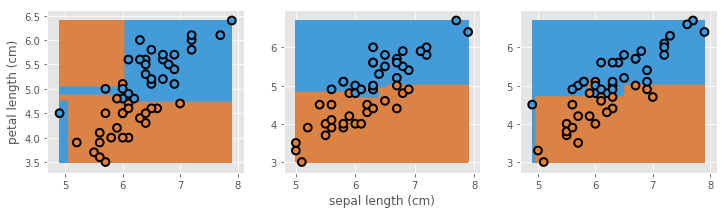

In [15]:
np.random.seed(123)

fig = plt.figure(figsize=[12,3])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    
    # generate indices in a random order
    idx = np.random.permutation(X.shape[0])
    
    # only use the first 50
    idx = idx[:50]
    X_temp = X[idx,:]
    y_temp = y[idx]
    
    # initialize the model
    mdl = tree.DecisionTreeClassifier(max_depth=5)
    
    # train the model using the dataset
    mdl = mdl.fit(X_temp, y_temp)
    
    # only specify labels once for clarity
    xlabel = feat[0] if i == 1 else None
    ylabel = feat[1] if i == 0 else None
        
    plot_model_pred_2d(mdl, X_temp, y_temp, xlabel=xlabel, ylabel=ylabel, cbar=False)
    
plt.show()

Above we can see that we are using random subsets of data, and as a result, our decision boundary can change quite a bit. As you could guess, we actually don't want a model that randomly works well and randomly works poorly, so you may wonder why this is useful. The trick is that by combining many of instances of "high variance" classifiers (decision trees), we can end up with a single classifier with low variance. There is an old joke: two farmers and a statistician go hunting. They see a deer: the first farmer shoots, and misses to the left. The next farmer shoots, and misses to the right. The statistician yells "We got it!!". 

While it doesn't quite hold in real life, it turns out that this principle does hold for decision trees - combining them in the right way ends up building powerful models.

## Boosting

The premise of boosting is the combination of many weak learners to form a single "strong" learner. In a nutshell, boosting involves building a models iteratively, and at each step we focus on the data we performed poorly on. In our context, we'll use decision trees, so the first step would be to build a tree using the data. Next, we'd look at the data that we misclassified, and re-weight the data so that we really wanted to classify those observations correctly, at a cost of maybe getting some of the other data wrong this time. Let's see how this works in practice.

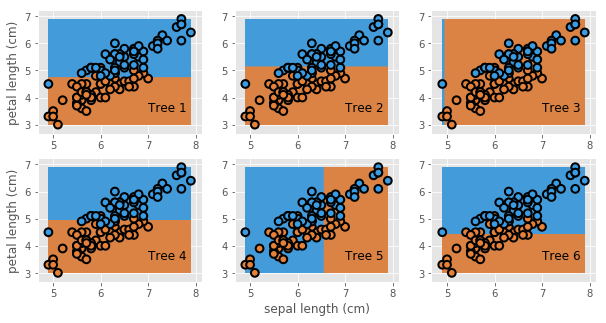

In [16]:
# build the model
clf = tree.DecisionTreeClassifier(max_depth=1)
mdl = ensemble.AdaBoostClassifier(base_estimator=clf,n_estimators=6)
mdl = mdl.fit(X,y)

# plot each individual decision tree
fig = plt.figure(figsize=[10,5])
for i, estimator in enumerate(mdl.estimators_):
    xlabel = feat[0] if i == 4 else None
    ylabel = feat[1] if i % 3 == 0 else None
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, xlabel=xlabel, ylabel=ylabel, cbar=False)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

Looking at the above, we can see that the first iteration builds the exact same simple decision tree as we had seen earlier. This makes sense - it's using the entire dataset with no special weighting. 

In the next iteration we can see the model shift - it misclassified five observations in class 1, and now these are the most important observations. Consequently, it picks the boundary that, while prioritizing correctly classifies these observations, still tries to best classify the rest of the data too. Now we have correctly classified all but one observation, the one on the far left middle of the graph. In iteration 3, the algorithm solely focuses on correctly classifying this one observation.

One important point is that each tree is weighted by it's global error. In the figure above, it's obvious that we wouldn't want to weight Tree 3 equally to Tree 1, when Tree 1 is doing so much better overall. It turns out that weighting each tree by the inverse of its error is a pretty good way to do this.

Let's look at final model's decision surface.

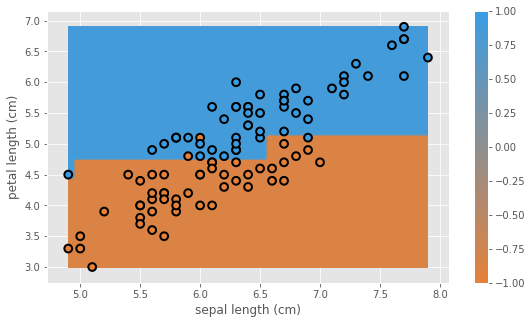

In [17]:
# plot the final prediction
plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

And that's AdaBoost! There are a few tricks we have glossed over here - but you understand the general principle. Now we'll move on to a different approach. With boosting, we iteratively changed the dataset to have new trees focus on the "difficult" observations. The next approach we discuss is similar as it also involves using changed versions of our dataset to build new trees.

## Bagging

Bootstrap aggregation, or "Bagging", is another form of *ensemble learning* where we aim to build a single good model by combining many models together. With AdaBoost, we modified the data to focus on hard to classify observations. We can imagine this as a form of resampling the data for each new tree. For example, say we have three observations: A, B, and C, `[A, B, C]`. If we correctly classify observations `[A, B]`, but incorrectly classify `C`, then AdaBoost involves building a new tree that focuses on `C`. Equivalently, we could say AdaBoost builds a new tree using the dataset `[A, B, C, C, C]`, where we have *intentionally* repeated observation `C` 3 times so that the algorithm thinks it is 3 times as important as the other observations. Before we move on, convince yourself that this makes sense.

Bagging involves the exact same approach, except we don't selectively choose which observations to focus on, but rather we *randomly select subsets of data each time*. As you can see, while this is a similar process to AdaBoost, the concept is quite different. Whereas before we aimed to iteratively improve our overall model with new trees, we now build trees on what we hope are independent datasets.

Let's take a step back, and think about a practical example. Say we wanted a good model of heart disease. If we saw researchers build a model from a dataset of patients from their hospital, we would be happy. If they then acquired a new dataset from new patients, and built a new model, we'd be inclined to feel that the combination of the two models would be better than any one individually. This exact scenario is what bagging aims to replicate, except instead of actually going out and collecting new datasets, we instead use bootstraping to create new sets of data from our current dataset. If you are unfamiliar with bootstrapping, you can treat it as "magic" for now (and if you are familiar with the bootstrap, you already know it's magic).

Let's take a look at a simple bootstrap model with the iris dataset.

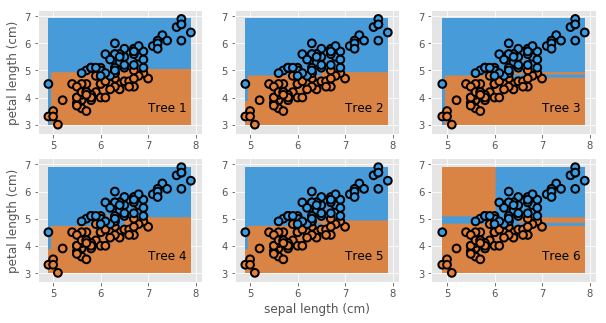

In [18]:
np.random.seed(321)
clf = tree.DecisionTreeClassifier(max_depth=5)
mdl = ensemble.BaggingClassifier(base_estimator=clf, n_estimators=6)
mdl = mdl.fit(X,y)

fig = plt.figure(figsize=[10,5])
for i, estimator in enumerate(mdl.estimators_):
    xlabel = feat[0] if i == 4 else None
    ylabel = feat[1] if i % 3 == 0 else None
    
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, xlabel=xlabel, ylabel=ylabel, cbar=False)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

We can see that each individual tree is quite variable - this is a result of using a random set of data to train the classifier.

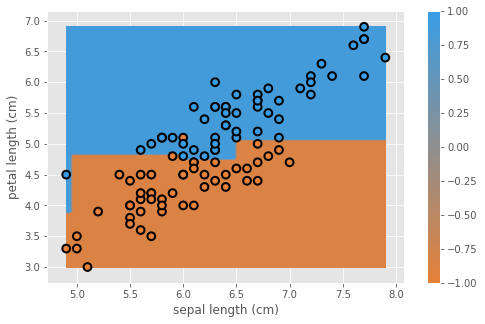

In [19]:
# plot the final prediction
plt.figure(figsize=[8,5])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

Not bad! Of course, since this is a simple dataset, we are not seeing that many dramatic changes between different models. Don't worry, we'll quantitatively evaluate them later.

Next up, a minor addition creates one of the most popular models in machine learning.

# Random Forest

Above, we used bagging to randomly resample our data to generate "new" datasets to build trees from. The Random Forest takes this one step further: instead of just resampling our data, we also select only a fraction of the features to include. It turns out that this subselection tends to improve the performance of our models. The odds of an individual being very good or very bad is higher (i.e. the variance of the trees is increased), and this ends up giving us a final model with better overall performance (lower bias).

Let's train the model now.

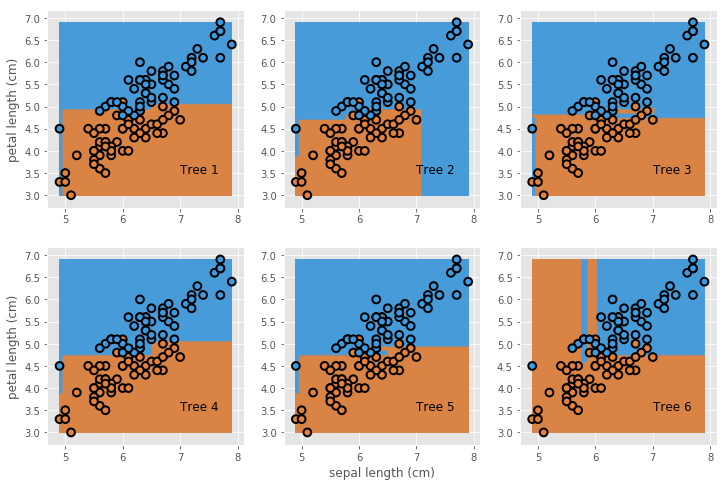


Plotting final decision surface



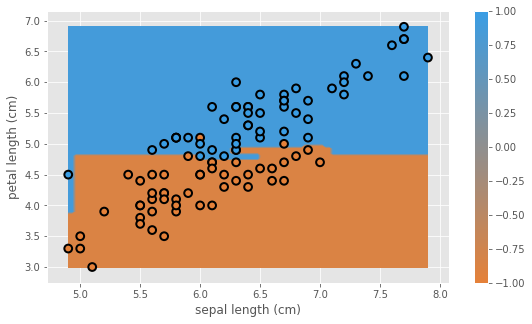

In [20]:
np.random.seed(321)
mdl = ensemble.RandomForestClassifier(max_depth=5, n_estimators=6, max_features=1)
mdl = mdl.fit(X,y)

fig = plt.figure(figsize=[12,8])
for i, estimator in enumerate(mdl.estimators_):
    
    xlabel = feat[0] if i == 4 else None
    ylabel = feat[1] if i % 3 == 0 else None
    
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, xlabel=xlabel, ylabel=ylabel, cbar=False)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

print('\nPlotting final decision surface\n')
plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

Again, the visualization doesn't *really* show us the power of Random Forests, but we'll quantitatively evaluate them soon enough.

Last, and not least, we move on to gradient boosting.

## Gradient Boosting

Gradient boosting (GB) is our last topic - and elegantly combines concepts from the previous methods. 
As a "boosting" method, GB involves iteratively building trees, aiming to improve upon misclassifications of the previous tree. GB also borrows the concept of sub sampling the number of columns (as was done in Random Forests), which tends to prevent overfitting.

While it is hard to express in this non-technical tutorial, the biggest innovation in GB is that it provides a unifying mathematical framework for boosting models.
GB explicitly casts the problem of building a tree as an optimization problem, defining mathematical functions for how well a tree is performing (which we had before) *and* how complex a tree is. In this light, one can actually treat AdaBoost as a "special case" of GB, where the loss function is chosen to be the exponential loss.

Let's build a GB model.


Plotting final decision surface



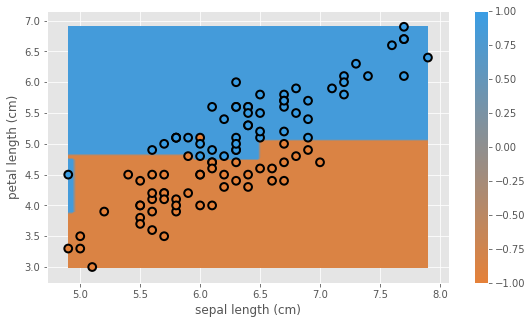

In [21]:
np.random.seed(321)
mdl = ensemble.GradientBoostingClassifier(n_estimators=10)
mdl = mdl.fit(X, y)

print('\nPlotting final decision surface\n')
plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, xlabel=feat[0], ylabel=feat[1])
plt.show()

# Running through a slightly harder dataset

We've now learned the basics of the various tree methods and have visualized most of them on the Fisher iris data. We now move on to a harder classification problem involving the identification of breast cancer tumours from features describing cell nuclei of breast mass. The goal is to classify whether the mass is cancerous or not. 

In [22]:
# real example
df_bc = datasets.load_breast_cancer()

# if you want a description of the dataset, uncomment the below line
print(df_bc['DESCR'])

# pick index of the features to use (only pick 2)
#    :Attribute Information (in order):
#        0 - CRIM     per capita crime rate by town
#        1 - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#        2 - INDUS    proportion of non-retail business acres per town
#        3 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#        4 - NOX      nitric oxides concentration (parts per 10 million)
#        5 - RM       average number of rooms per dwelling
#        6 - AGE      proportion of owner-occupied units built prior to 1940
#        7 - DIS      weighted distances to five Boston employment centres
#        8 - RAD      index of accessibility to radial highways
#        9 - TAX      full-value property-tax rate per $10,000
#       10 - PTRATIO  pupil-teacher ratio by town
#       11 - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#       12 - LSTAT    % lower status of the population
#       13 - MEDV     Median value of owner-occupied homes in $1000's


idx = [1,29]
X = df_bc['data'][:,idx]
y = df_bc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30, random_state=42)

feat = [x for x in df_bc['feature_names'][idx]]

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Above, we've extracted two features out of the breast cancer dataset. We'll use these to quickly visualize all the models we have presented here. We'll also print out their performance as measured by the AUROC.

AUROC	Model
0.674	Decision Tree
0.807	Gradient Boosting
0.789	Random Forest
0.802	Bagging
0.801	AdaBoost


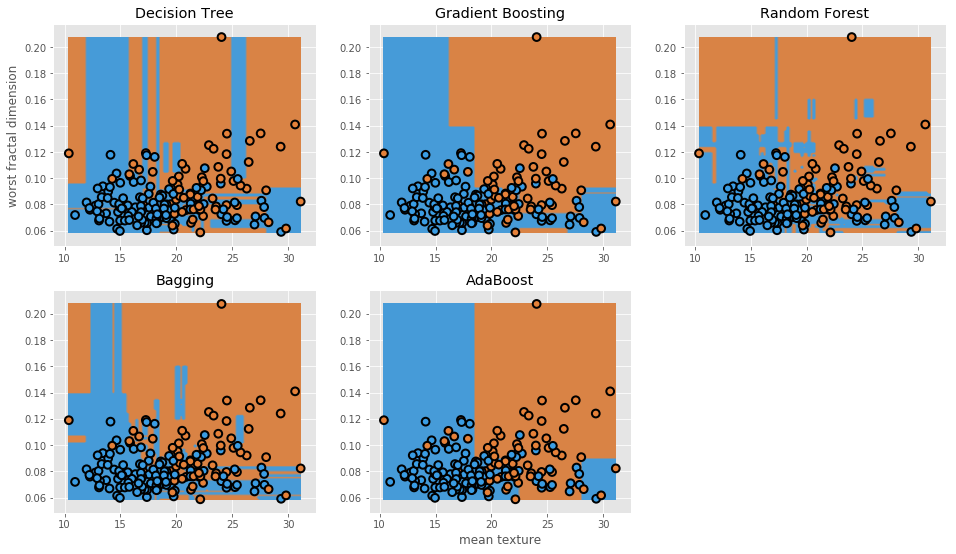

In [23]:
clf = dict()
clf['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', splitter='best').fit(X_train,y_train)
clf['Gradient Boosting'] = ensemble.GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train)
clf['Random Forest'] = ensemble.RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
clf['Bagging'] =  ensemble.BaggingClassifier(n_estimators=10).fit(X_train, y_train)
clf['AdaBoost'] =  ensemble.AdaBoostClassifier(n_estimators=10).fit(X_train, y_train)

fig = plt.figure(figsize=[16,9])

print('AUROC\tModel')
for i, curr_mdl in enumerate(clf):
    xlabel = feat[0] if i == 4 else None
    ylabel = feat[1] if i == 0 else None
    
    yhat = clf[curr_mdl].predict_proba(X_test)[:,1]
    score = metrics.roc_auc_score(y_test, yhat)
    print('{:0.3f}\t{}'.format(score, curr_mdl))
    ax = fig.add_subplot(2,3,i+1)
    
    plot_model_pred_2d(clf[curr_mdl], X_test, y_test, xlabel=xlabel, ylabel=ylabel, cbar=False)
    
    plt.title(curr_mdl)
    
plt.show()

Here we can see that quantitatively, AdaBoost and Gradient Boosting have produced the highest discrimination among all the models (~0.80). The decision surfaces of these models also seem simpler, and less "noisy", which tends to result in improved generalization on the held out test set (this is not a rule, just Occam's razor in action).

Now we will include all features of the breast cancer dataset. As a result, we will no longer be able to easily visualize the models, but we will be able to better evaluate them. We'll also switch to using 5-fold cross-validation to get a good estimate of the generalization performance of the model.

In [24]:
X = df_bc['data']
y = df_bc['target']

# use cross-validation to estimate the performance of each model
print('Acc\tAUROC\tModel')
for curr_mdl in clf:
    scores = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='accuracy')
    auc = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='roc_auc')
    print('{:0.3f}\t{:0.3f}\t{}'.format(scores.mean(), auc.mean(), curr_mdl))

Acc	AUROC	Model
0.931	0.923	Decision Tree
0.946	0.981	Gradient Boosting
0.956	0.986	Random Forest
0.949	0.983	Bagging
0.946	0.988	AdaBoost


We can note two things:

* by using the entire feature set we have dramatically improved performance of the model, indicating that there was more information contained in the other columns
* most of our models are performing relatively equivalently (except for the super simple model, the decision tree).

To make appropriate comparisons, we should calculate 95% confidence intervals on these performance estimates. This can be done a number of ways; the easiest is to bootstrap the calculation.

# Exercise

We'll now practice using these models on a dataset acquired from patients admitted to intensive care units at the Beth Israel Deaconness Medical Center in Boston, MA. All patients in the cohort stayed for at least 48 hours, and the goal of the prediction task is to predict in-hospital mortality. This data is a subset of a publicly accessible ICU database: MIMIC. If you're interested, you can read more about MIMIC [here](https://mimic.physionet.org).
The particular dataset we are using is described in more detail here: http://physionet.org/challenge/2012/

The data is originally provided as a time series of observations for a number of variables, but to simplify the analysis, we've done some preprocessing to get a single row for each patient. 
The following cell will check if the data is available here. If it's not, it will download it to the subfolder `data` in the same folder as this notebook.

In [25]:
url = 'https://github.com/alistairewj/tree-prediction-tutorial/raw/master/data/PhysionetChallenge2012-set-a.csv.gz'
seta = pd.read_csv(url, sep=',', header=0, compression='gzip')
seta.set_index('recordid', inplace=True)
seta.head()

,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,CCU,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,0,...,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,0,...,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,0,...,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
132543,7,1,9,575,0,68.0,1.0,180.3,84.6,0,...,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
132545,17,2,4,918,0,88.0,0.0,NaN,NaN,0,...,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# remove cheating variables from training data
X = seta.drop(['In-hospital_death', 'Survival', 'Length_of_stay'], axis=1).values
y = seta['In-hospital_death'].values

# here we only use the first 3000 observations as our training set
y_train = y[0:3000]
X_train = X[0:3000, :]

y_test = y[3000:]
X_test = X[3000:, :]

print('Training size: {} - {:6d} missing observations'.format(X_train.shape,
                                                           np.sum(np.sum(np.isnan(X_train)))))
print('Test size:     {} - {:6d} missing observations'.format(X_test.shape,
                                 np.sum(np.sum(np.isnan(X_test)))))

Training size: (3000, 116) -  87976 missing observations
Test size:     (1000, 116) -  29857 missing observations


The outcome is the first column `'In-hospital_death'`. The rest of the data are features you can use to predict this binary outcome.

Now, using what you've learned above, try to build the five classifiers using decision trees, AdaBoost, Random Forest, Bagging, and Gradient Boosting. Pick your favourite and play with the parameters to see how well you can do! Be sure to use cross-validation to make sure you don't overfit.

WARNING: You'll note that the above has a lot of missing data! We haven't dealt with this before, but it is a challenging issue with medical data. In general there are three types of missing data:

1. Missing completely at random (MCAR)
    * The data is missing for reasons *unrelated* to the data
    * a power outage results in losing vital sign data
2. Missing at random (MAR)
    * The data is missing for reasons related to the data, but not the missing observation
    * we don't collect lactate measurements on admission to a medical ICU, but we collect them for cardiac ICU
3. Missing not at random (MNAR)
    * The data is missing, and the reason it is missing *depends* on the value
    * a doctor does not order the Troponin-I lab test, because they believe it to be normal
  
  
The hardest case to deal with is MNAR, and unfortunately, that is the most common in the medical domain. Still, we have to do something, so we often use approaches which are theoretically invalid under MNAR but in practice work acceptably well.

Below, we'll replace missing data with the average value for the training population.

In [28]:
# Impute missing data

# since decision trees do not handle missing data, we impute it here
mu = np.nanmean(X_train, axis=0)

for i in range(X_train.shape[0]):
    idxMissing = np.isnan(X_train[:, i])
    X_train[idxMissing, i] = mu[i]
    
    idxMissing = np.isnan(X_test[:,i])
    X_test[idxMissing, i] = mu[i]

# now we should find that we have no more missing data!

print('Training size: {} - {:6d} missing observations'.format(X_train.shape,
                                                           np.sum(np.sum(np.isnan(X_train)))))
print('Test size:     {} - {:6d} missing observations'.format(X_test.shape,
                                 np.sum(np.sum(np.isnan(X_test)))))

Training size: (3000, 116) -      0 missing observations
Test size:     (1000, 116) -      0 missing observations


Now that the missing data is handled, try to build the above tree models using the ICU data!

In [29]:
clf_pn = dict()
auc = dict()

In [30]:
# Instantiate a decision tree classifier
mdl_dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')

# Fit the model to the training data
mdl_dt = mdl_dt.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl_dt.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, yhat)

# Add the trained model to our dictionary which has all the models
clf_pn['Decision Tree'] = mdl_dt

# Add the AUROC to an AUROC dictionary
auc['Decision Tree'] = score

In [31]:
# Instantiate an AdaBoost classifier
mdl_adaboost = ensemble.AdaBoostClassifier(n_estimators=10)

# Fit the model to the training data
mdl_adaboost = mdl_adaboost.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl_adaboost.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, yhat)

# Add the trained model to our dictionary which has all the models
clf_pn['AdaBoost'] = mdl_dt

# Add the AUROC to an AUROC dictionary
auc['AdaBoost'] = score

In [32]:
# Instantiate a random forest
mdl_rf = ensemble.RandomForestClassifier(n_estimators=10)

# Fit the model to the training data
mdl_rf = mdl_rf.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl_rf.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, yhat)

# Add the trained model to our dictionary which has all the models
clf_pn['Random Forest'] = mdl_rf

# Add the AUROC to an AUROC dictionary
auc['Random Forest'] = score

In [33]:
# Instantiate a Gradient Boosting classifier
mdl_gb = ensemble.GradientBoostingClassifier(n_estimators=10)

# Fit the model to the training data
mdl_gb = mdl_gb.fit(X_train, y_train)

# evaluate the model on the test set
yhat = mdl_gb.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, yhat)

# Add the trained model to our dictionary which has all the models
clf_pn['Gradient Boosting'] = mdl_gb

# Add the AUROC to an AUROC dictionary
auc['Gradient Boosting'] = score

In [34]:
# Compare the 4 above models
print('AUROC\tModel')
for i, curr_mdl in enumerate(clf_pn):
    print('{:0.3f}\t{}'.format(auc[curr_mdl], curr_mdl))

AUROC	Model
0.577	Decision Tree
0.804	AdaBoost
0.729	Random Forest
0.804	Gradient Boosting


## Pipeline

A really great way of building models is to use `pipeline` from scikit-learn. This allows us to define the steps in our preprocessing *with* the ultimate model. It's a great feature that simplifies a lot of the tedium in preprocessing. Here's an example imputing missing data.

In [35]:
# Let's define the features we want to use here

# below says "all features in the dataset, except these three"
# model_features = [x for x in seta.columns if x not in ['Length_of_stay', 'Survival', 'In-hospital_death']]

model_features = ['Age', 'Gender', 'Height', 'Weight', 'CCU', 'SysABP_last', 'TroponinI_last', 'MechVentDuration']
target_feature = 'In-hospital_death'

In [36]:
# use pipeline to automatically apply preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# choose the classifier - here it's a simple logistic regression
base_mdl = LogisticRegression(penalty='l2', solver='lbfgs')

# our pipeline will
#  (1) impute 0 if MechVentDuration is missing - since that implies no mech vent
#  (2) impute the mean for continuous variables - Imputer  
mechvent_features = [x for x in ['MechVentStartTime', 'MechVentDuration', 'MechVentLast8Hour'] if x in model_features]

# be sure to exclude the mechvent features from our numeric features
numeric_features = [x for x in model_features if x not in mechvent_features]

# We create separate preprocessing pipelines for numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

mechvent_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# You could also consider a transformer which converts categorical data into a bunch of features of 0s/1s
# so called "one-hot" encoding
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('mv', mechvent_transformer, mechvent_features)])

mdl = Pipeline([("preprocessor", preprocessor),
                ('model', base_mdl)])

Now that the pipeline is prepared, we can easily fit it on our data:

In [37]:
# Train the model
mdl = mdl.fit(seta[model_features], seta[target_feature])

And evaluate the predictions!

In [38]:
lr_prob = mdl.predict_proba(seta)[:,1]
print("AUROC Train: {:0.3f}".format(metrics.roc_auc_score(seta[target_feature], lr_prob)))

AUROC Train: 0.684


Of course the above is optimistic (train and evaluate on the same dataset). We can also take advantage of sklearn's cross-validation tools to easily do cross-validation.

In [39]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mdl, seta[model_features], seta[target_feature], cv=5, scoring='roc_auc')
print("AUROC: {:0.3f} [{:0.3f}, {:0.3f}]".format(np.mean(scores), np.min(scores), np.max(scores)))

AUROC: 0.678 [0.615, 0.712]


Check out [Tuning the hyper-parameters of an estimator](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) in the scikit-learn documentation for info on how to use CV to tweak the parameters of a model.

# Keep exploring!

The above models work fairly well, but there is room for improvement!

* Are there other ways to impute missing data?
* Have we thought about the features in our data, and how we are using them?
* Have we visualized the data? Are there any obvious outliers which may fool our model?
  *  Note: a lot of outliers were removed by custom preprocessing I did, but some may remain
* Are there parameters of our model which we could change?
* Is there a systematic way of choosing the parameters of our model?

The below code downloads a second set of data - `set-b`. This is the same type of data from a distinct 4000 patients, but this time you don't have the answers!

In [40]:
url = 'https://github.com/alistairewj/tree-prediction-tutorial/raw/master/data/PhysionetChallenge2012-set-b-no-outcome.csv.gz'
setb = pd.read_csv(url, sep=',', header=0, compression='gzip')
setb.set_index('recordid', inplace=True)
setb.head()

,SAPS-I,SOFA,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,
142675,27,14,70,1.0,175.3,85.0,0,1,0,60.0,...,105.0,NaN,NaN,6.1,NaN,7.38,99.0,2559.0,1.0,13.0
142676,12,1,57,0.0,NaN,NaN,0,0,0,NaN,...,NaN,NaN,NaN,15.1,NaN,NaN,NaN,NaN,NaN,NaN
142680,12,7,60,1.0,182.9,78.8,0,0,0,49.0,...,104.0,NaN,NaN,17.6,79.5,7.45,207.0,2570.0,1.0,20.0
142683,19,15,64,1.0,180.3,145.2,0,1,0,76.0,...,140.0,NaN,NaN,18.3,NaN,7.36,374.0,2420.0,1.0,14.0
142688,3,0,51,1.0,172.7,90.0,0,0,1,55.0,...,107.0,NaN,NaN,12.5,NaN,7.37,NaN,NaN,NaN,NaN
